In [1]:
import os
import numpy as np
import pickle
import random
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import math
import copy
from sklearn.utils import shuffle
from textblob import TextBlob
import pandas as pd
import re
import emoji as emoji

df = pd.read_csv("Tweets.csv")

In [26]:
df[df["airline_sentiment"]=="negative"].shape[0] / df.shape[0]

0.6269125683060109

## negative is a major class. So, we may consider balance the data in the future analysis

# Process Data

In [4]:
# not test yet
# def sub_removeat(df):
#     val = re.sub(r"@\w+", "",df["text"])
#     return val
# df['remove'] = df.apply(sub_removeat, axis=1) # remove anything starts with @

### (1): remove "@" and remove any URL (assume it always starts with http)

In [5]:
def sub_remove(df):
    val = re.sub('@', "",df["text"]) 
    val = re.sub(r"http\w+","",val) # remove http://
    return val
df['remove_1'] = df.apply(sub_remove, axis=1) # remove anything starts with @


In [6]:
df = shuffle(df)
# choose the 80% for test  for training data
train_df = df[:11712].reset_index()
test_df = df[11712:].reset_index()


In [7]:
def read_data(file):
    lines = file.split(' ')
    symbols = '@$#{}()[].,:;+-*/&|<>=~" '
    table = str.maketrans("a", "a", symbols)
    words = map(lambda Element: Element.translate(table).strip(), lines)
    words = list(filter(None, words))
    for i in range(len(words)):
        try:
            words[i] = emoji.demojize(words[i])  # converting emoji to 
        except:
            pass 
    
    return words

In [8]:
# WIP

def read_data_demojize(file):
    lines = file.split(' ')
    symbols = '@$#{}()[].,:;+-*/&|<>=~" '
    table = str.maketrans("a", "a", symbols)
    words = map(lambda Element: Element.translate(table).strip(), lines)
    words = list(filter(None, words))
    for i in range(len(words)):
        if words[i] in emoji.UNICODE_EMOJI:
            words.remove(words[i])
    return words


In [9]:
def char_is_emoji(character):
    return character in emoji.UNICODE_EMOJI

In [10]:
#df["remove_1"][18].lower()

read_data('i ❤️ flying virginamerica. ☺️👍')

['i', ':red_heart:️', 'flying', 'virginamerica', ':smiling_face:️:thumbs_up:']

In [11]:
def process_data(database,col_name="remove_1"):
    x_list = list()
    y_list = list() 
    for i in range(database.shape[0]):
        line = database[col_name][i].lower()
        x_list.append(read_data(line))
        y_list.append(database["airline_sentiment"][i])
            
    return x_list,y_list 

In [12]:
X_train,y_train = process_data(train_df)
X_test,y_test = process_data(test_df)


In [13]:
def sparse_count(dataset):
    count_list = list()
    for i in dataset:
        count_list.append(dict(Counter(i)))
    return count_list

X_train_sparse = sparse_count(X_train)
X_test_sparse = sparse_count(X_test)

In [14]:
def dotProduct(d1, d2):
    """
    @param dict d1: a feature vector represented by a mapping from a feature (string) to a weight (float).
    @param dict d2: same as d1
    @return float: the dot product between d1 and d2
    """
    if len(d1) < len(d2):
        return dotProduct(d2, d1)
    else:
        return sum(d1.get(f, 0) * v for f, v in d2.items())

In [15]:
def increment(d1, scale, d2):
    """
    Implements d1 += scale * d2 for sparse vectors.
    @param dict d1: the feature vector which is mutated.
    @param float scale
    @param dict d2: a feature vector.

    NOTE: This function does not return anything, but rather
    increments d1 in place. We do this because it is much faster to
    change elements of d1 in place than to build a new dictionary and
    return it.
    """
    for f, v in d2.items():
        d1[f] = d1.get(f, 0) + v * scale


In [16]:
def predict_loss(w,X,y):
    loss = 0 
    for i in range(len(X)):
        pred = dotProduct(w,X[i])
        if pred * y[i] < 0:
            loss += 1 
    return loss / len(X)
    

In [17]:
# re-define pegasos by adding randomly shuffule data for mutilple round run 
def pegasos_2(X,y,Lambda,max_round = 50):
    t = 1
    s = 1 
    round_count = 0
    W = dict()
    
    while round_count < max_round:
        
        index_list = list(range(len(X))) 
        random.shuffle(index_list) # shuffle everytime 
        round_count += 1 
        for i in index_list:
            t+= 1
            nt = 1/(t*Lambda)
            s = (1-nt * Lambda) * s 
            if y[i]*s*dotProduct(W,X[i]) < 1:
                increment(W,(1/s)*nt*y[i],X[i])
    
    increment(W,(s-1),W) #rescale w= W+(s-1)W

    return W

In [18]:
def svm_pegasos(y_train_y,y_test_y,label):
    y_train = copy.deepcopy(y_train_y)
    for i in range(len(y_train)):
        if y_train[i] == label:
            y_train[i] = 1
        else:
            y_train[i] = -1  
            
    y_test = copy.deepcopy(y_test_y)
    for i in range(len(y_test)):
        if y_test[i] == label:
            y_test[i] = 1
        else:
            y_test[i] = -1
    w_list = list()
    Lambda_list = list()
    loss_list = list()

    for i in range(-10,4):
        Lambda_list.append(10**i)
        w_inuse = pegasos_2(X_train_sparse,y_train,10**i)
        w_list.append(w_inuse)
        loss = predict_loss(w_inuse,X_test_sparse,y_test)
        loss_list.append(loss)
    best_Lambda = Lambda_list[np.argmin((np.array(loss_list)))]
    best_w = w_list[np.argmin((np.array(loss_list)))]
    print ("Best Lambda to choose:", best_Lambda)
    print ("Minimum loss is:",min(loss_list))
    fig = plt.figure(figsize = (8,4))
    plt.plot(Lambda_list,loss_list)
    plt.xscale('log')
    plt.title("Searching for Lambda for the validation loss")
    plt.show()
    pred_score_list = list()
    pred_list = list()
    abs_pred_score_list = list()
    correction = list()
    for i in range(len(X_test_sparse)):
        pred_score_list.append(dotProduct(best_w,X_test_sparse[i]))
        abs_pred_score_list.append(abs(dotProduct(best_w,X_test_sparse[i])))

        if dotProduct(best_w,X_test_sparse[i]) > 0:
            pred_list.append(1)
        else:
            pred_list.append(-1)

        if dotProduct(best_w,X_test_sparse[i])*y_test[i] > 0:
            correction.append(1)
        else:
            correction.append(0)
    return pred_score_list

Best Lambda to choose: 0.001
Minimum loss is: 0.14685792349726776


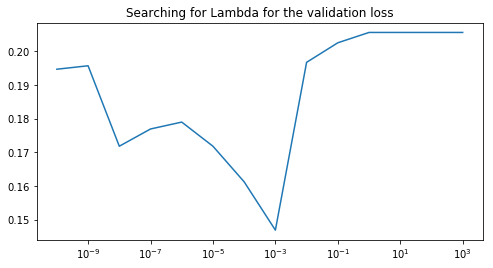

Best Lambda to choose: 0.001
Minimum loss is: 0.15778688524590165


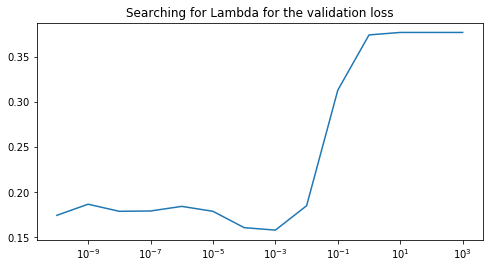

Best Lambda to choose: 0.0001
Minimum loss is: 0.09596994535519125


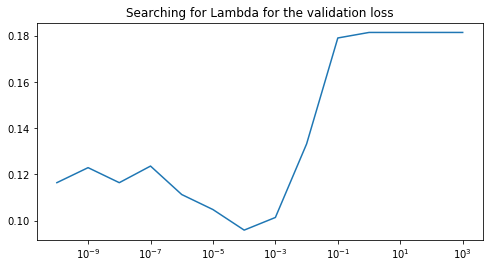

In [19]:
pred_score_list_neutral = svm_pegasos(y_train,y_test,"neutral")
pred_score_list_negative = svm_pegasos(y_train,y_test,"negative")
pred_score_list_positive = svm_pegasos(y_train,y_test,"positive")

In [20]:

result = pd.DataFrame.from_dict({'Correct': y_test,
         'positive': pred_score_list_positive,
         'negative': pred_score_list_negative,
         'neutral': pred_score_list_neutral})


In [21]:
result["predict"] = result[["negative","neutral","positive"]].idxmax(axis=1)

In [22]:
#result["predict"][1]
result

,Correct,negative,neutral,positive,predict
0,negative,1.296104,-1.371241,-1.946718,negative
1,neutral,0.399589,-0.739411,-2.100406,negative
2,positive,-1.671787,-0.677936,1.024588,positive
3,neutral,-1.226091,-0.913591,1.075818,positive
4,negative,2.050884,-2.209696,-0.802594,negative
5,negative,1.446377,-0.952867,-3.449448,negative
6,neutral,-0.059768,-1.451500,-0.102459,negative
7,neutral,-0.401297,0.512294,-2.066253,neutral
8,negative,2.122606,-2.325816,-4.286195,negative
9,negative,0.886269,-0.932375,-2.049177,negative


In [23]:
correct_count = 0 
for i in range(result.shape[0]):
    if result["Correct"][i] == result["predict"][i]:
        correct_count =  correct_count+1
        
correct_count / result.shape[0]

0.807035519125683

### AUC

### with balanced training by random sampling 

### extension introduce a weighted  loss function by class # class-senstive loss function 

### tf-idf 

### try bi-grams and n-grams

### try using both at the same time 

### scklearnt package 

### bow tf-idf 

### balanced data 

### other evaluation metrics (extension precesion/recall, AUC,) 

### different models  vs different performance 

### boosting (balance not really need, but can try and compare) 


### DIFFERENT METRICS 

